In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
import shap
shap.initjs()

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [18]:
df_init = pd.read_csv('data_v3.csv', sep=';')
df_init.head()

,Id,Number,Result,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_106,...,Feature_99,Feature_100,Feature_111,Feature_1122,Feature_112,Feature_113,Feature_114,Feature_115,Feature_116,Feature_117
0,1,10359/C2020,2,2,56,12,1,7.0,4,2,...,0.0,0.0,1,0,1,1,1.0,1,1,0
1,2,10346/C2020,2,2,69,19,1,6.0,4,2,...,0.0,0.0,1,0,1,1,1.0,0,1,1
2,3,10311/C2020,2,1,66,8,1,4.0,4,2,...,0.0,0.0,1,0,1,1,1.0,0,1,0
3,4,10292/C2020,2,2,62,16,1,NaN,3,2,...,0.0,0.0,1,0,1,1,0.0,0,1,1
4,5,10283/C2020,2,2,67,30,1,NaN,4,2,...,0.0,0.0,1,0,1,1,1.0,0,1,0


In [19]:
def distrib_plot(df: pd.DataFrame, f: str, y: str):
    x_mean_class_0 = round(df[df[y] == 0][f].mean(), 2)
    x_mean_class_1 = round(df[df[y] == 1][f].mean(), 2)

    plt.figure(figsize = (20, 5))

    sns.distplot(df[df[y] == 0][f], hist=False, color='orange')
    sns.distplot(df[df[y] == 1][f], hist=False, color='blue')

    plt.axvline(x_mean_class_0, label=f'class_0={x_mean_class_0}', color='orange', linestyle=':')
    plt.axvline(x_mean_class_1, label=f'class_1={x_mean_class_1}', color='blue', linestyle='--')

    plt.title(f'Distribution of {f}')
    plt.legend()

In [20]:
def train(df, trash_features = []):

    df_ = df.copy()

    target_feature = 'Result'

    usefull_features = []
    useless_features = ['Id', 'Number', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_17', 'Feature_18', 'Feature_23', 
                        'Feature_29', 'Feature_30', 'Feature_32','Feature_33', 'Feature_34',
                        'Feature_35', 'Feature_54', 'Feature_65', 'Feature_94', 'Feature_101', 'Feature_108','Feature_111', 
                        'Feature_112','Feature_113', 'Feature_114','Feature_115', 'Feature_116', 'Feature_117']
    
    features_to_drop = [target_feature] + useless_features
    for feature in trash_features:
        if feature not in usefull_features and feature not in useless_features:
            features_to_drop.append(feature)

    all_features = df_.columns.drop(features_to_drop).tolist()

    df_ = df_[[target_feature] + all_features]

    num_features = ['Feature_2', 'Feature_3', 'Feature_33', 'Feature_34', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 
                    'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 
                    'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_53', 'Feature_55', 'Feature_57', 
                    'Feature_58', 'Feature_59', 'Feature_64', 'Feature_70', 'Feature_71', 'Feature_72', 'Feature_73']
    
    special_features = ['Feature_17', 'Feature_18', 'Feature_23', 'Feature_74', 'Feature_75', 'Feature_76', 'Feature_77', 
                        'Feature_78', 'Feature_79', 'Feature_80', 'Feature_81', 'Feature_82', 'Feature_83', 'Feature_84', 
                        'Feature_85', 'Feature_86', 'Feature_87', 'Feature_88', 'Feature_89', 'Feature_90', 'Feature_91', 
                        'Feature_92', 'Feature_93', 'Feature_94', 'Feature_95', 'Feature_96', 'Feature_97', 'Feature_98', 
                        'Feature_99', 'Feature_100']
    
    for col in special_features:
        if col in df_.columns:
            df_[col].fillna(0, inplace=True)

    cat_features = []
    for col in df_.drop(target_feature, axis=1).columns:
        if col in num_features:
            df_[col].fillna(df_[col].median(), inplace=True)
            df_[col] = df_[col].astype('float64')
        else:
            cat_features.append(col)
            df_[col].fillna(-1, inplace=True)
            df_[col] = df_[col].astype('int64')
    
    # Result=0 - alive, Result=1 died
    df_.loc[df_[target_feature] == 1, target_feature] = 0
    df_.loc[df_[target_feature] == 2, target_feature] = 1

    df_train, df_test = train_test_split(
        df_,
        shuffle=True,
        test_size=0.25,
        random_state=0,
        stratify=df_[target_feature],
    )

    # Separate majority and minority classes
    df_majority = df_train[df_train[target_feature] == 1]
    df_minority = df_train[df_train[target_feature] == 0]
    
    # Upsample majority class
    df_majority_upsampled = resample(
        df_majority,
        replace=True,
        n_samples=100,
        random_state=0,
    )
    # Upsample minority class
    df_minority_upsampled = resample(
        df_minority,
        replace=True,
        n_samples=100,
        random_state=0,
    )
    # Combine minority class with downsampled majority class
    df_train_sampled = pd.concat([df_majority_upsampled, df_minority_upsampled])

    X_train = df_train_sampled[all_features]
    y_train = df_train_sampled[target_feature]

    X_test = df_test[all_features]
    y_test = df_test[target_feature]

    train_pool = Pool(
        X_train,
        y_train,
        cat_features=cat_features
    )

    params_frozen = {
        'eval_metric': 'Accuracy',
        'early_stopping_rounds': 50,
        'one_hot_max_size': 20,
        'verbose': 0,
    }

    params_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.03, 0.1, 0.3, 0.5],
        'iterations': [100, 200, 400, 600, 800, 1000, 1200],
        'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
        'bagging_temperature': [1, 1.5, 2, 2.5],
        'random_strength': [1, 1.5, 2]
    }

    clf = CatBoostClassifier(**params_frozen)
    rs = clf.randomized_search(
        params_grid,
        train_pool,
        n_iter=5,
        shuffle=True,
        stratified=True,
        partition_random_seed=0,
        cv=5,
        calc_cv_statistics=False,
        search_by_train_test_split=False,
        refit=True,
    )

    return clf, df_, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature

In [21]:
trash_features = []
epochs = 5
for epoch in range(1, epochs+1):

    print(f"\nEpoch {epoch} from {epochs}\n{'=' * 50}")

    clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
        df_init,
        trash_features=trash_features,
    )

    test_pool = Pool(
        X_test,
        y_test,
        cat_features=cat_features
    )
    y_test_pred = clf.predict(test_pool)

    print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
    print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

    feature_importances = pd.DataFrame(
        zip(X_train.columns, clf.get_feature_importance()),
        columns=['feature_name', 'importance']
    )

    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    features = feature_importances[feature_importances['importance'] < 1 ]['feature_name'].tolist()
    if trash_features:
        if not features:
            print('Train stopped')
            break

        for feature in features:
            if feature not in trash_features:
                trash_features.append(feature)
    else:
        trash_features=features

    print('Fetures to drop')
    print(trash_features)


Epoch 1 from 5
Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.8850000	best: 0.8850000 (0)	total: 3.03s	remaining: 12.1s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.8800000	best: 0.8850000 (0)	total: 26.6s	remaining: 39.9s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.8800000	best: 0.8850000 (0)	total: 36s	remaining: 24s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.8950000	best: 0.8950000 (3)	total: 42.2s	remaining: 10.6s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.8600000	best: 0.8950000 (3)	total: 1m 19s	remaining: 0us
Accuracy: 0.75
F1 Score: 0.75

Classification report: 
              precision    recall  f1-score   support

           0       0.77      0.74      0.75        31
           1       0.74      0.77      0.75        30

    accuracy                           0.75        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.75      0.75      0.75    

In [22]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

for feature in feature_importances[15:]['feature_name'].tolist():
    if feature not in trash_features:
        trash_features.append(feature)

In [23]:
clf, df, X_train, X_test, y_train, y_test, all_features, cat_features, target_feature = train(
    df_init,
    trash_features=trash_features,
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features
)
y_test_pred = clf.predict(test_pool)
y_test_pred_proba = clf.predict_proba(test_pool)

print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'F1 Score: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'\nClassification report: \n{classification_report(y_test, y_test_pred)}')

Stopped by overfitting detector  (50 iterations wait)
0:	loss: 0.9050000	best: 0.9050000 (0)	total: 7.2s	remaining: 28.8s
Stopped by overfitting detector  (50 iterations wait)
1:	loss: 0.8650000	best: 0.9050000 (0)	total: 13.5s	remaining: 20.3s
Stopped by overfitting detector  (50 iterations wait)
2:	loss: 0.9050000	best: 0.9050000 (2)	total: 20.5s	remaining: 13.6s
Stopped by overfitting detector  (50 iterations wait)
3:	loss: 0.8850000	best: 0.9050000 (2)	total: 24.5s	remaining: 6.14s
Stopped by overfitting detector  (50 iterations wait)
4:	loss: 0.8750000	best: 0.9050000 (2)	total: 39.9s	remaining: 0us
Accuracy: 0.77
F1 Score: 0.76

Classification report: 
              precision    recall  f1-score   support

           0       0.76      0.81      0.78        31
           1       0.79      0.73      0.76        30

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



In [24]:
feature_importances = pd.DataFrame(
    zip(X_train.columns, clf.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(50)

,feature_name,importance
9,Feature_47,10.844266
8,Feature_41,9.018799
5,Feature_36,8.946047
10,Feature_51,8.669638
0,Feature_6,7.683958
12,Feature_70,7.386215
7,Feature_40,7.321733
11,Feature_59,7.195883
14,Feature_73,6.963049
1,Feature_106,6.627857


## Shapley values: features importance

In [25]:
explainer = shap.TreeExplainer(clf)
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

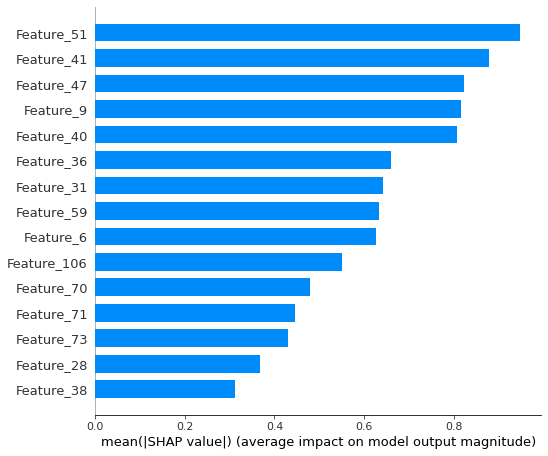

In [26]:
shap.summary_plot(shap_values_train, X_train, plot_type="bar", max_display=20)

## Shapley values: summary plot

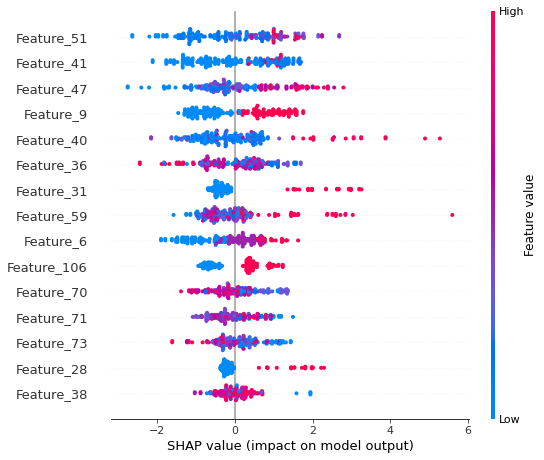

In [27]:
shap.summary_plot(shap_values_train, X_train, max_display=20)

## Features distribution by classes

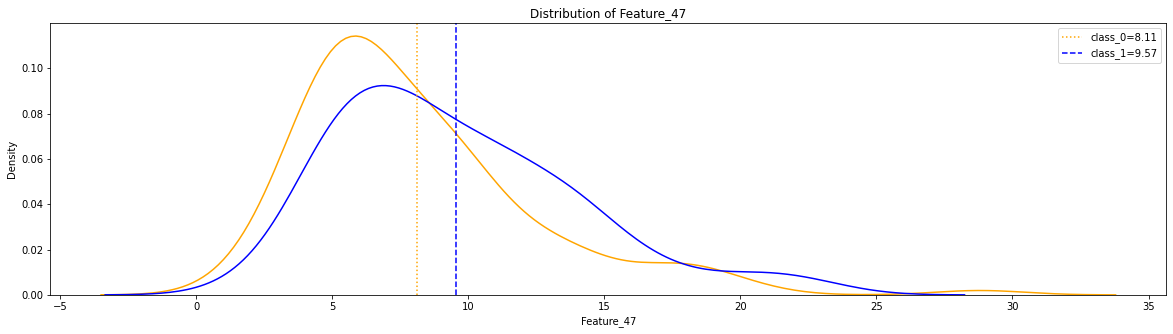

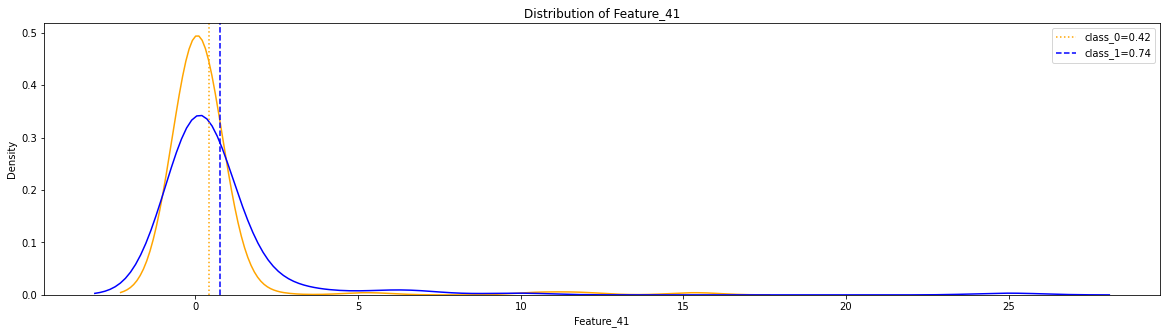

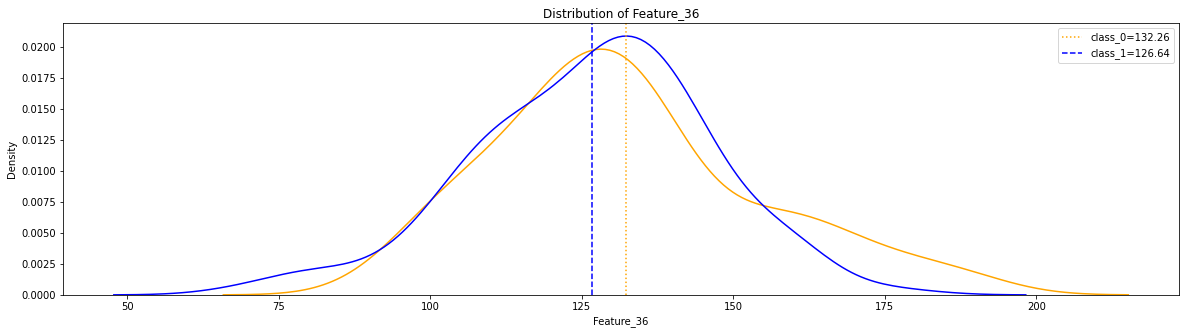

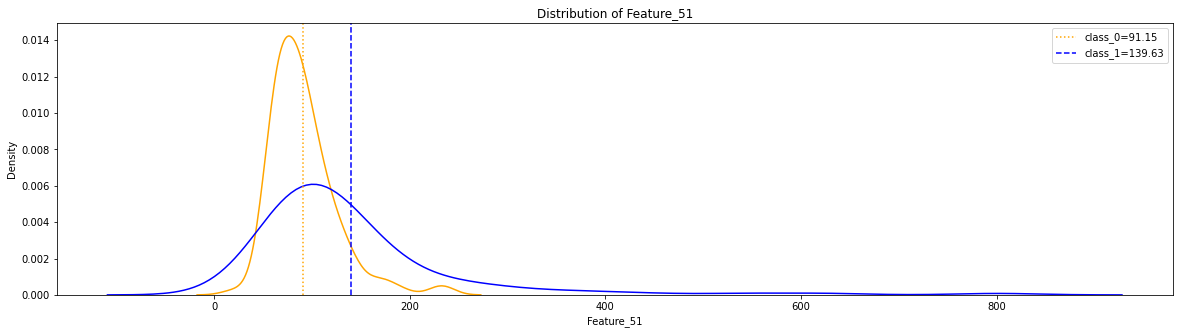

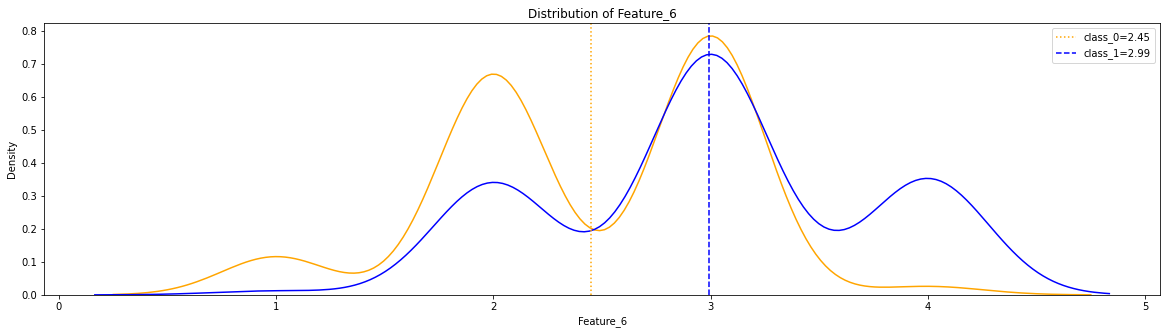

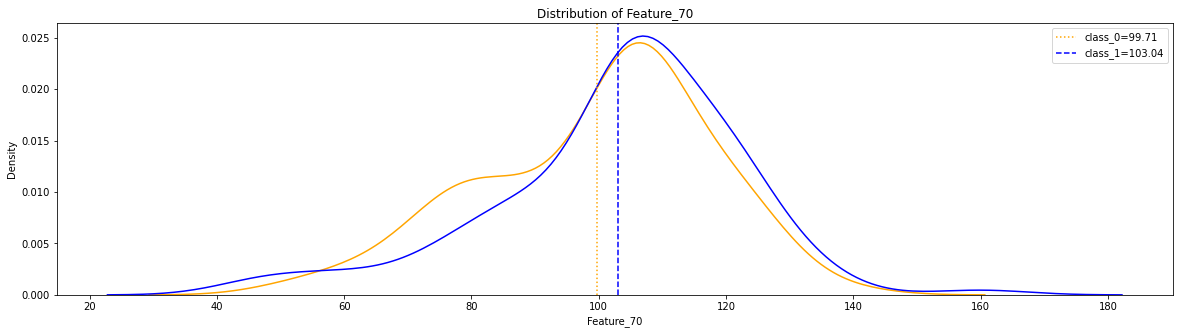

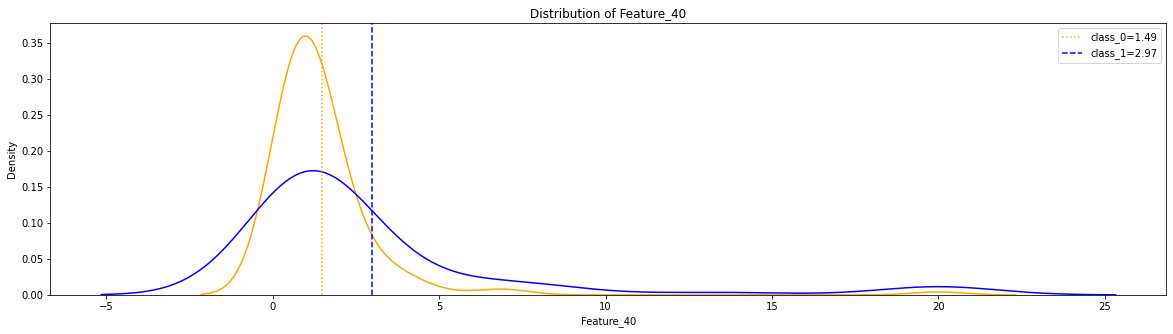

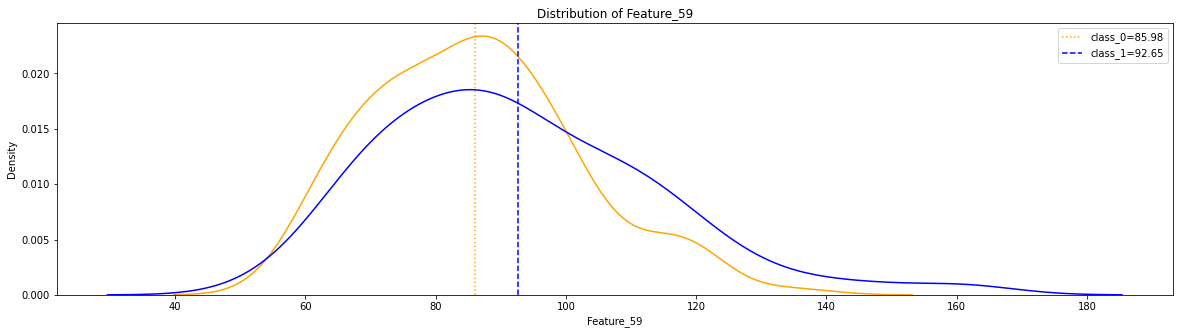

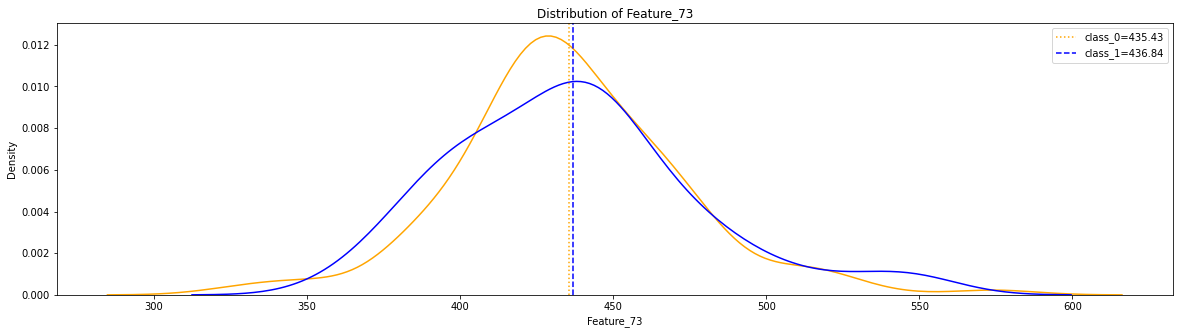

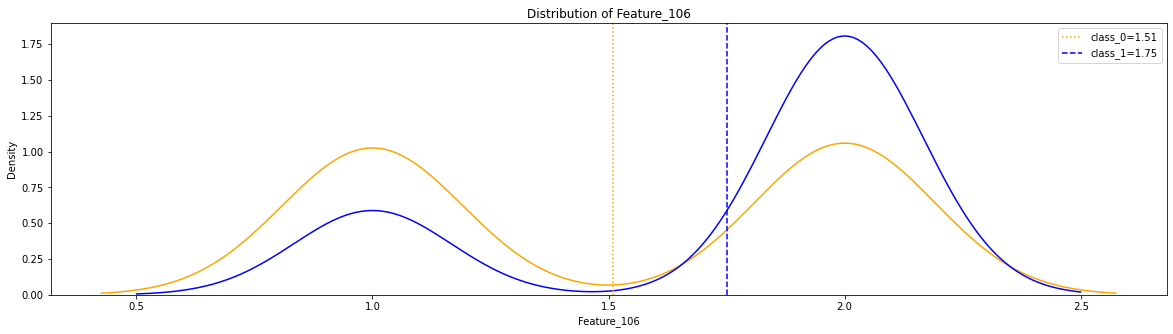

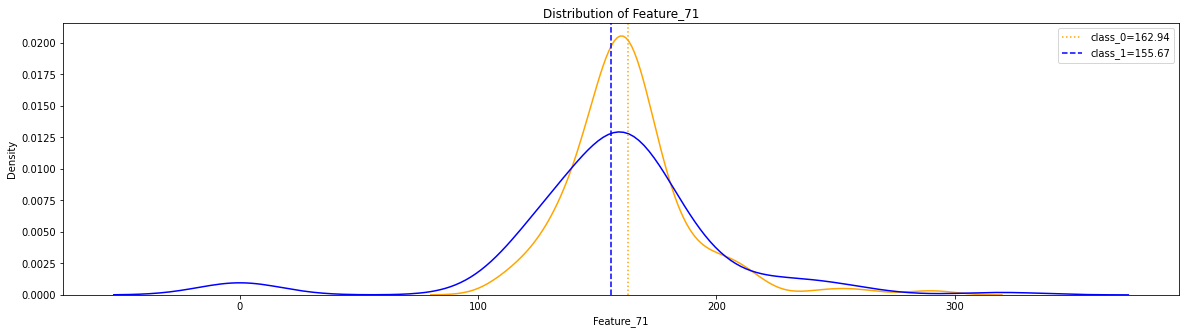

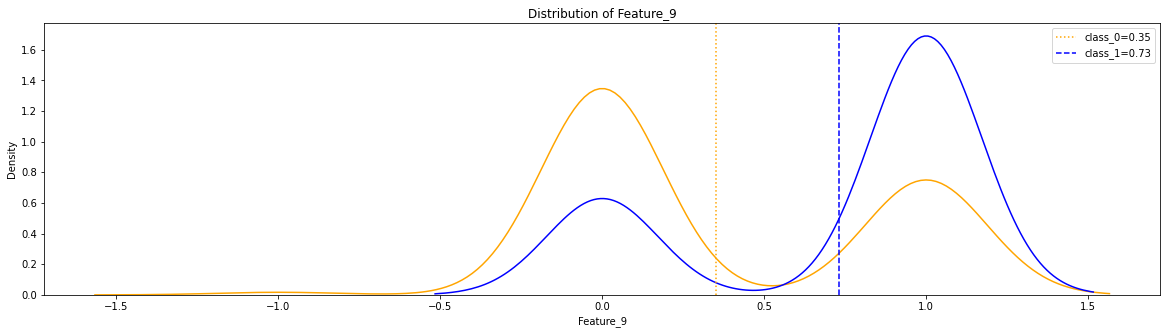

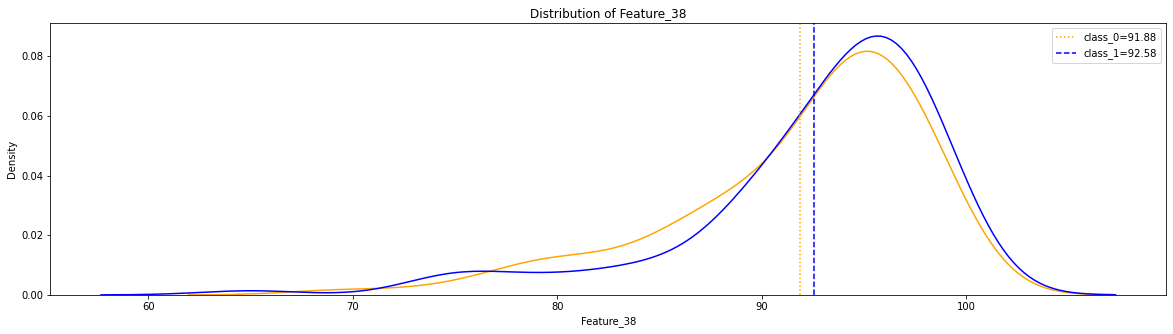

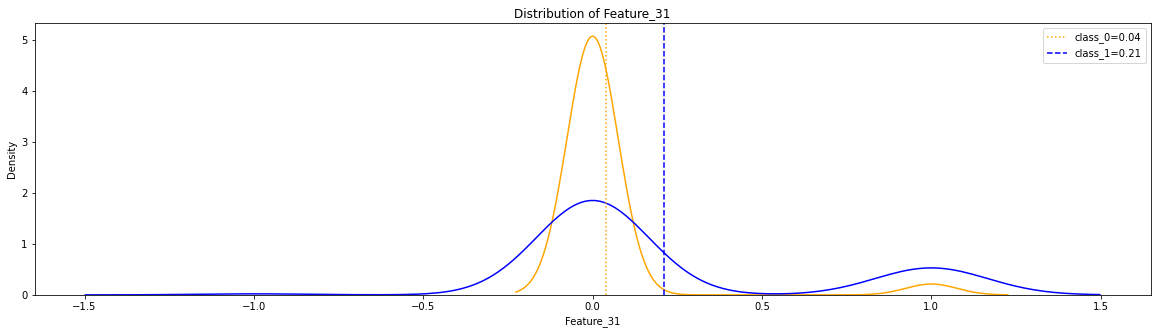

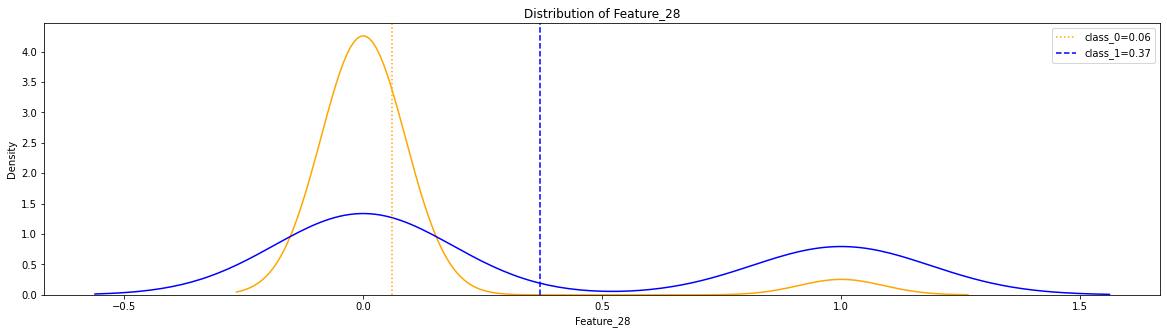

In [28]:
for feature in feature_importances['feature_name']:
    distrib_plot(df, feature, 'Result')

## Errors

In [29]:
df_explain_table = X_test.copy()
df_explain = X_test.copy()

df_explain_table['Result_true'] = y_test
df_explain_table['Result_pred'] = y_test_pred
df_explain_table['Result_pred_proba'] = y_test_pred_proba[:, 1:2]

In [30]:
df_errors = df_explain_table[df_explain_table['Result_true'] != df_explain_table['Result_pred']]
df_errors.T

,54,35,227,82,237,43,234,188,144,135,0,206,36,67
Feature_6,3.000000,2.000000,3.000000,3.000000,3.000000,3.0000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,4.000000,3.000000
Feature_106,2.000000,1.000000,2.000000,2.000000,2.000000,2.0000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
Feature_9,0.000000,0.000000,1.000000,0.000000,1.000000,1.0000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
Feature_28,0.000000,0.000000,0.000000,0.000000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Feature_31,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Feature_36,142.000000,140.000000,120.000000,80.000000,160.000000,158.0000,120.000000,156.000000,130.000000,132.000000,125.000000,107.000000,115.000000,130.000000
Feature_38,98.000000,90.000000,87.000000,98.000000,94.000000,75.0000,78.000000,95.000000,89.000000,94.000000,84.000000,85.000000,94.000000,94.000000
Feature_40,3.370000,0.490000,0.670000,2.490000,1.290000,3.2100,2.410000,1.220000,1.300000,1.220000,0.270000,0.630000,0.380000,1.470000
Feature_41,0.050000,0.020000,0.040000,0.030000,0.113000,0.0700,0.040000,0.030000,0.000000,0.030000,0.030000,0.050000,0.020000,0.200000
Feature_47,4.900000,2.600000,18.600000,6.000000,14.100000,5.2000,3.900000,19.200000,21.900000,12.400000,8.900000,13.900000,5.200000,8.800000


In [31]:
print('Cases in which the model is wrong\n')

for row in df_errors.index:
    print(f'#{row + 1} \t {df_init.iloc[row]["Number"]}')

Cases in which the model is wrong

#55 	 10440/C2020
#36 	 10680/C2020
#228 	 10873/C2020
#83 	 11144/C2020
#238 	 10710/C2020
#44 	 10583/C2020
#235 	 11598/C2020
#189 	 12183/C2020
#145 	 104/C2021
#136 	 10118/C2020
#1 	 10359/C2020
#207 	 10364/C2020
#37 	 10678/C2020
#68 	 11625/C2020


## Confusion matrix

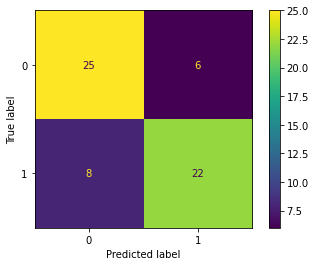

In [32]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(2))

disp.plot(values_format ='.3g')
plt.show()